In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [17]:
!pip3 install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.fft import fft
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [22]:
data = pd.read_csv('/content/drive/MyDrive/H4TF - Business 2/100000 Sales Records.csv')

In [23]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], format='%m/%d/%Y')
data = data.sort_values(by='Order Date').reset_index(drop=True)

In [24]:
def create_features(data):
    data['Order Year'] = data['Order Date'].dt.year
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day

    data['Ship Year'] = data['Ship Date'].dt.year
    data['Ship Month'] = data['Ship Date'].dt.month
    data['Ship Day'] = data['Ship Date'].dt.day

    data['Shipping Time'] = (data['Ship Date'] - data['Order Date']).dt.days
    data['On Time Delivery'] = np.where(data['Shipping Time'] <= 4, 1, 0)
    data['Order DayOfWeek'] = data['Order Date'].dt.dayofweek
    data['Ship DayOfWeek'] = data['Ship Date'].dt.dayofweek
    return data

data = create_features(data)

In [25]:
daily_revenue = data.groupby(['Order Date'])['Total Revenue'].sum().reset_index()
daily_revenue.columns = ['Order Date', 'Daily Total Revenue']

daily_order_count = data.groupby(['Order Date'])['Order ID'].count().reset_index()
daily_order_count.columns = ['Order Date', 'Daily Order Count']

daily_units_sold = data.groupby(['Order Date'])['Units Sold'].sum().reset_index()
daily_units_sold.columns = ['Order Date', 'Daily Units Sold']

daily_avg_price = data.groupby(['Order Date'])['Unit Price'].mean().reset_index()
daily_avg_price.columns = ['Order Date', 'Daily Avg Price']


In [26]:
daily_shipping_time = data.groupby(['Order Date'])['Shipping Time'].mean().reset_index()
daily_shipping_time.columns = ['Order Date', 'Average Shipping Time']

daily_on_time_delivery = data.groupby(['Order Date'])['On Time Delivery'].mean().reset_index()
daily_on_time_delivery.columns = ['Order Date', 'On Time Delivery Rate']

In [27]:
# Gộp các đặc trưng tổng hợp vào dataframe chính
daily_data = daily_revenue
daily_data = daily_data.merge(daily_order_count, on='Order Date')
daily_data = daily_data.merge(daily_units_sold, on='Order Date')
daily_data = daily_data.merge(daily_avg_price, on='Order Date')
daily_data = daily_data.merge(daily_shipping_time, on='Order Date')
daily_data = daily_data.merge(daily_on_time_delivery, on='Order Date')

In [28]:
# Đếm số lượng đơn hàng mỗi ngày theo từng giá trị của các biến phân loại
region_count = data.groupby(['Order Date', 'Region'])['Order ID'].count().unstack().fillna(0).reset_index()
region_count.columns = ['Order Date'] + [f'Count_{col}' for col in region_count.columns[1:]]

country_count = data.groupby(['Order Date', 'Country'])['Order ID'].count().unstack().fillna(0).reset_index()
country_count.columns = ['Order Date'] + [f'Count_{col}' for col in country_count.columns[1:]]

item_type_count = data.groupby(['Order Date', 'Item Type'])['Order ID'].count().unstack().fillna(0).reset_index()
item_type_count.columns = ['Order Date'] + [f'Count_{col}' for col in item_type_count.columns[1:]]

sales_channel_count = data.groupby(['Order Date', 'Sales Channel'])['Order ID'].count().unstack().fillna(0).reset_index()
sales_channel_count.columns = ['Order Date'] + [f'Count_{col}' for col in sales_channel_count.columns[1:]]

order_priority_count = data.groupby(['Order Date', 'Order Priority'])['Order ID'].count().unstack().fillna(0).reset_index()
order_priority_count.columns = ['Order Date'] + [f'Count_{col}' for col in order_priority_count.columns[1:]]

# Tổng doanh thu mỗi ngày theo từng giá trị của các biến phân loại
region_revenue = data.groupby(['Order Date', 'Region'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
region_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in region_revenue.columns[1:]]

country_revenue = data.groupby(['Order Date', 'Country'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
country_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in country_revenue.columns[1:]]

item_type_revenue = data.groupby(['Order Date', 'Item Type'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
item_type_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in item_type_revenue.columns[1:]]

sales_channel_revenue = data.groupby(['Order Date', 'Sales Channel'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
sales_channel_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in sales_channel_revenue.columns[1:]]

order_priority_revenue = data.groupby(['Order Date', 'Order Priority'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
order_priority_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in order_priority_revenue.columns[1:]]


In [29]:
daily_data = daily_data.merge(region_count, on='Order Date')
daily_data = daily_data.merge(country_count, on='Order Date')
daily_data = daily_data.merge(item_type_count, on='Order Date')
daily_data = daily_data.merge(sales_channel_count, on='Order Date')
daily_data = daily_data.merge(order_priority_count, on='Order Date')

daily_data = daily_data.merge(region_revenue, on='Order Date')
daily_data = daily_data.merge(country_revenue, on='Order Date')
daily_data = daily_data.merge(item_type_revenue, on='Order Date')
daily_data = daily_data.merge(sales_channel_revenue, on='Order Date')
daily_data = daily_data.merge(order_priority_revenue, on='Order Date')


In [30]:
daily_data.set_index('Order Date', inplace=True)

In [31]:
train_data = daily_data['2010-01-01':'2016-12-31']
test_data = daily_data['2017-01-01':'2017-12-31']

In [32]:
feature_columns = train_data.columns.drop(['Daily Total Revenue'])
X_train = train_data[feature_columns]
y_train = train_data['Daily Total Revenue']
X_test = test_data[feature_columns]
y_test = test_data['Daily Total Revenue']

In [34]:
param_grid = {
    'iterations': [500],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [5, 7, 9],
    'border_count': [32, 64]
}

In [35]:
model = CatBoostRegressor(verbose=1)

In [36]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)


In [40]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

0:	learn: 11006568.4891155	total: 60.1ms	remaining: 30s
1:	learn: 10345545.0138056	total: 70.9ms	remaining: 17.6s
2:	learn: 9704062.7364387	total: 81.2ms	remaining: 13.4s
3:	learn: 9169869.0941602	total: 92.3ms	remaining: 11.4s
4:	learn: 8588356.0741736	total: 103ms	remaining: 10.2s
5:	learn: 8043397.8238087	total: 113ms	remaining: 9.29s
6:	learn: 7556712.2640879	total: 123ms	remaining: 8.69s
7:	learn: 7066067.8103533	total: 134ms	remaining: 8.25s
8:	learn: 6676512.6755641	total: 145ms	remaining: 7.93s
9:	learn: 6288040.1002427	total: 156ms	remaining: 7.65s
10:	learn: 5941858.5580826	total: 167ms	remaining: 7.43s
11:	learn: 5545673.2839220	total: 178ms	remaining: 7.22s
12:	learn: 5237398.9609025	total: 187ms	remaining: 7.01s
13:	learn: 4902934.3963074	total: 197ms	remaining: 6.84s
14:	learn: 4652412.5957908	total: 207ms	remaining: 6.7s
15:	learn: 4426136.1363773	total: 217ms	remaining: 6.57s
16:	learn: 4152237.6832964	total: 227ms	remaining: 6.46s
17:	learn: 3914515.9460559	total: 237m

In [43]:
model = CatBoostRegressor(**best_params)

In [44]:
model.fit(X_train, y_train)

0:	learn: 11006568.4891155	total: 29.9ms	remaining: 14.9s
1:	learn: 10345545.0138056	total: 52.5ms	remaining: 13.1s
2:	learn: 9704062.7364387	total: 84.4ms	remaining: 14s
3:	learn: 9169869.0941602	total: 117ms	remaining: 14.5s
4:	learn: 8588356.0741736	total: 150ms	remaining: 14.9s
5:	learn: 8043397.8238087	total: 179ms	remaining: 14.7s
6:	learn: 7556712.2640879	total: 215ms	remaining: 15.1s
7:	learn: 7066067.8103533	total: 248ms	remaining: 15.3s
8:	learn: 6676512.6755641	total: 274ms	remaining: 14.9s
9:	learn: 6288040.1002427	total: 300ms	remaining: 14.7s
10:	learn: 5941858.5580826	total: 326ms	remaining: 14.5s
11:	learn: 5545673.2839220	total: 347ms	remaining: 14.1s
12:	learn: 5237398.9609025	total: 371ms	remaining: 13.9s
13:	learn: 4902934.3963074	total: 394ms	remaining: 13.7s
14:	learn: 4652412.5957908	total: 414ms	remaining: 13.4s
15:	learn: 4426136.1363773	total: 438ms	remaining: 13.3s
16:	learn: 4152237.6832964	total: 466ms	remaining: 13.2s
17:	learn: 3914515.9460559	total: 489m

In [46]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [47]:
def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Calculate evaluation metrics for training data
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    train_mse = mean_squared_error(y_true_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_true_train, y_pred_train)

    # Calculate evaluation metrics for testing data
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Print evaluation metrics
    print(f"Training Data: MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}, R-squared: {train_r2}")
    print(f"Testing Data: MAE: {test_mae}, MSE: {test_mse}, RMSE: {test_rmse}, R-squared: {test_r2}")

    # Return metrics as a dictionary
    metrics_dict = {
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    return metrics_dict

In [48]:
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Training Data: MAE: 341582.6421712401, MSE: 184660870143.7476, RMSE: 429721.85206683126, R-squared: 0.9986717180478385
Testing Data: MAE: 555808.9545532747, MSE: 538673758170.31323, RMSE: 733943.9748170928, R-squared: 0.9958055847375206


{'train_mae': 341582.6421712401,
 'train_mse': 184660870143.7476,
 'train_rmse': 429721.85206683126,
 'train_r2': 0.9986717180478385,
 'test_mae': 555808.9545532747,
 'test_mse': 538673758170.31323,
 'test_rmse': 733943.9748170928,
 'test_r2': 0.9958055847375206}

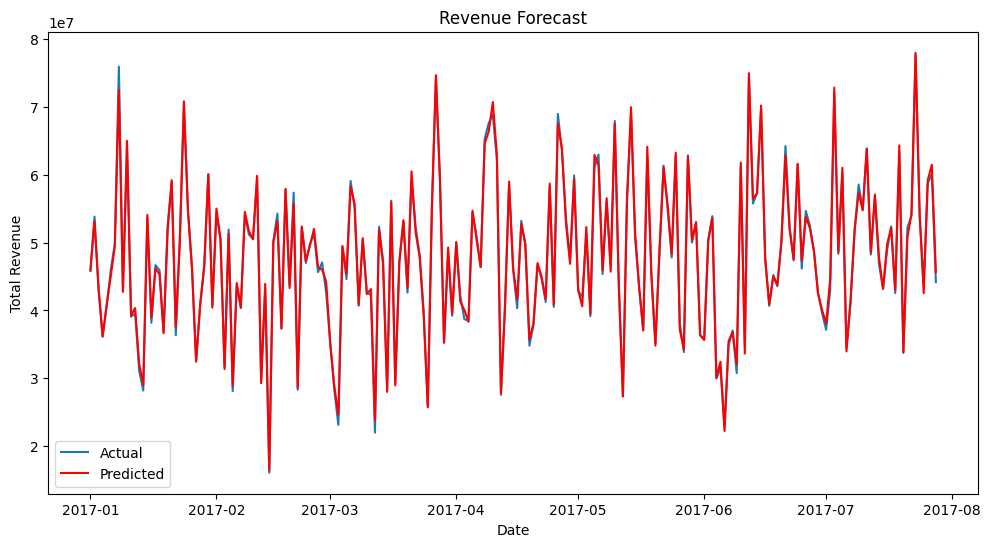

In [49]:
plt.figure(figsize=(12,6))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_test_pred, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Revenue Forecast')
plt.show()